### Random Forests and Photo-zs

In this notebook, we use Random Forests to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). It is adapted from a notebook written for Chapter 6 of the book.

Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/).

Author: Viviana Acquaviva

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import astropy

from astropy.io import fits

#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

Data import

It's easiest IMO to read the data into a data frame using pandas:

In [4]:
with fits.open('DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [5]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [6]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [7]:
df.shape

(23822, 78)

I can select the columns I want, corresponding to the brightness of the galaxies in the six bands of interest.

In [8]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

The target property is the redshift. For this catalog, spectroscopic (more precise) redshifts are available in the column below.

In [9]:
target = df['zhelio']

In [10]:
features.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
5,23.552186,23.420734,23.010863,22.550723,22.277656,21.860866
6,23.983330,24.104438,23.461145,23.359428,22.929944,22.690175
7,24.665840,24.408938,23.544115,23.155140,22.706477,22.894691
8,23.518039,22.746858,21.571629,20.645176,20.428926,20.306110
9,22.755723,21.915841,21.393365,21.148952,21.052236,20.830114


In [11]:
target.head(10)

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
5    0.909043
6    0.502974
7    0.649839
8    0.679440
9    0.074078
Name: zhelio, dtype: float32

### Ok, we are now ready to run our first Random Forest model!

To get an idea of what we are shooting for, we can look at the figure of the paper.

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15.

To be fair, we are working with DEEP2/3 data, so our range is slightly different.

In [12]:
model = RandomForestRegressor()

In [13]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Establish benchmark.

In [14]:
scores = cross_validate(model,features,target, \
    cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                        return_train_score=True)

In [15]:
scores

{'fit_time': array([7.44966626, 7.66579461, 7.51966381, 7.56060529, 7.27601719]),
 'score_time': array([0.09627151, 0.10590386, 0.11608148, 0.09340429, 0.09263682]),
 'test_score': array([0.30081675, 0.31238896, 0.31075728, 0.30761175, 0.31213152]),
 'train_score': array([0.87406407, 0.87890089, 0.87720302, 0.87781713, 0.87378073])}

Note - it takes a litle time! Also, the scores are the R2 score (also known as the coefficient of determination, essentially a measure of correlation between true and predicted scores) at this point.

In [16]:
np.mean(scores['test_score'])

0.30874125147311166

In [17]:
np.mean(scores['train_score'])

0.8763531676939305

Looks like we have a ..... issue! Overfitting, high variance.

Let's also plot the predictions vs true values:

In [18]:
ypred = cross_val_predict(model,features,target, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0.0, 3.0)

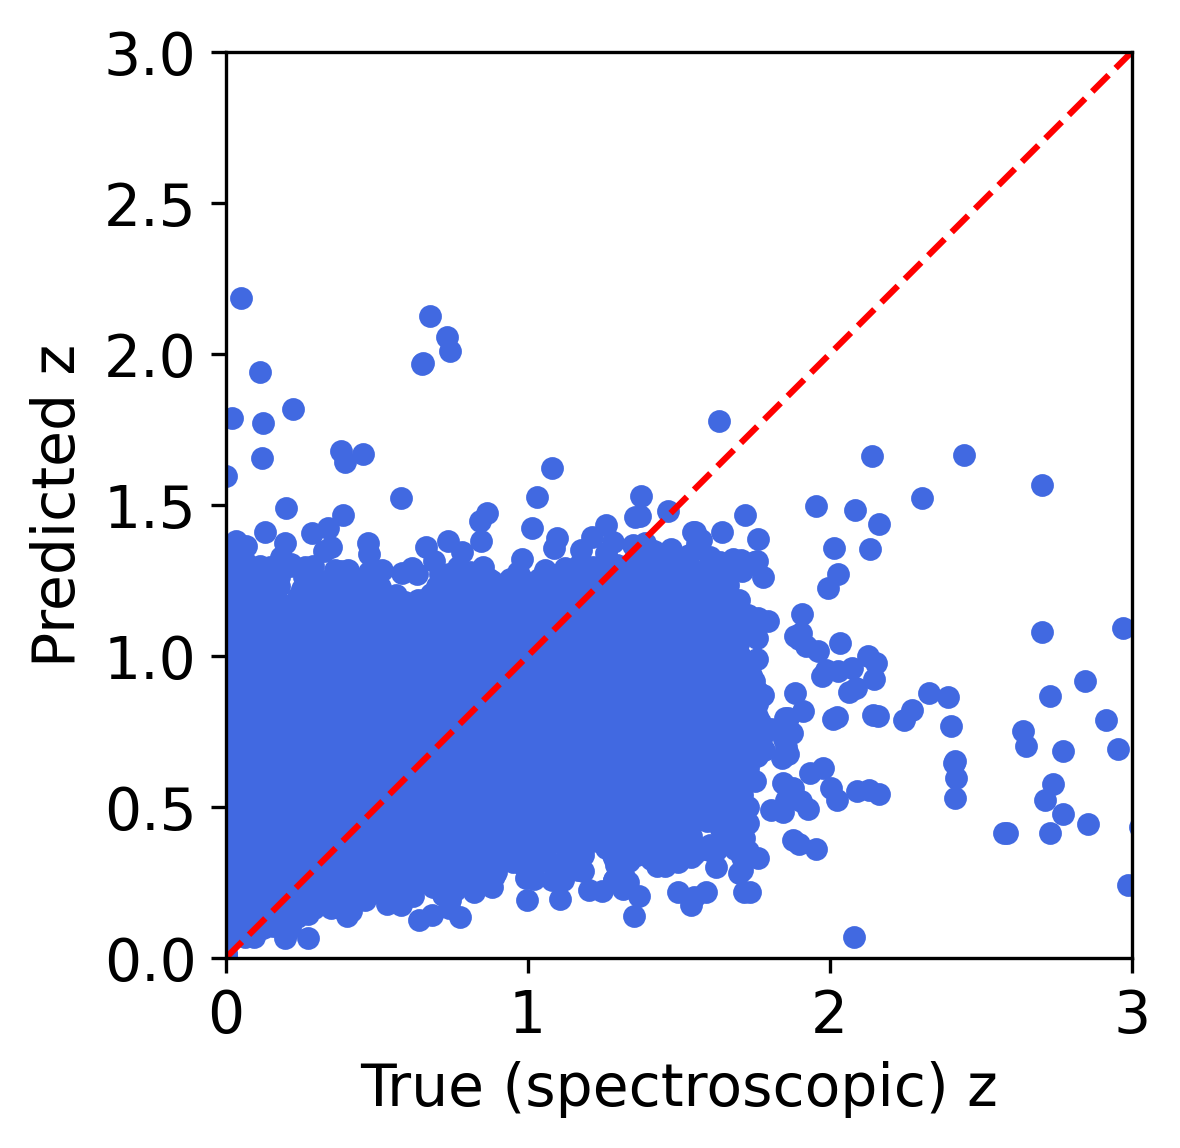

In [19]:
plt.scatter(target,ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
x = np.linspace(0,3,100)
y = x
plt.plot(x, y, linestyle='dashed', c='r', label='y=x')
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)

### Question: Does it look like the one of the paper?

For a fair comparison, we can calculate the outlier fraction, like in the paper:

In [20]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.2580387876752582

And the normalized median absolute deviation, or NMAD:

In [21]:
1.48*np.median(np.abs(target-ypred)/(1 + target)) 
#The 1.48 is there because for a Gaussian distribution, this becomes the standard deviation

0.07448238165966214

#### We have a pretty severe high variance issue; let's see if parameter optimization helps.

We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV.

In [22]:
np.random.seed(20)
ntrain = len(features)
sel = np.random.choice(range(len(features)), ntrain, replace = False) #sample without replacement

In [23]:
from sklearn.model_selection import train_test_split
sel, sel_test = train_test_split(sel, test_size=0.2)

In [24]:
len(np.unique(sel))

19057

And we create our new smaller data set.

In [25]:
seld = features.loc[sel,:]
selt = target[sel]

seld_test = features.loc[sel_test,:]
selt_test = target[sel_test]

In [26]:
# littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [27]:
# littlescores['test_score'].mean(), littlescores['train_score'].mean()

Similar performance on training set ensures that size of data set is not a big issue and we can proceed with optimization.

The parameters that we can consider varying include:

#### Tree Parameters

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required to create a new split;

- The maximum depth of tree;

-  The criterion chosen to decide whether a split is worth making, expressed in terms of information gain;


#### Randomization Parameters

- The number of k < n features that are used to build trees.

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

We can find them here:

In [28]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's discuss a possible set.

max_depth, max_features, increas n_estimators, n_leaves

In [29]:
seld.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
10423,24.925338,24.136357,22.926392,21.710163,21.195688,-99.000000
17568,22.452628,21.415618,20.288384,19.836142,19.608309,-99.000000
22231,25.079738,24.355512,23.334964,22.789102,22.735625,-99.000000
21206,24.816484,24.486021,23.861832,23.260590,22.878103,-99.000000
23796,25.298183,24.505416,24.202082,23.987302,24.175154,-99.000000
17541,24.142261,23.729016,23.094103,23.027214,22.988223,-99.000000
13541,23.876779,23.682530,23.241844,22.650736,22.506095,-99.000000
13169,24.363590,23.444348,22.973828,22.741105,22.655150,22.688658
8074,24.557732,24.479149,24.320924,23.865042,23.513233,23.557985
18190,23.752160,23.500453,23.143274,22.791387,22.299410,-99.000000


In [30]:
len(seld.columns)
selt.head()

10423    1.104324
17568    0.372083
22231    0.514079
21206    0.825409
23796    0.584154
Name: zhelio, dtype: float32

In [31]:
seld.index == selt.index

array([ True,  True,  True, ...,  True,  True,  True])

In [32]:
# First, remove inconsistent values
seld_filtered = seld
for colname in seld.columns:
    seld_filtered = seld_filtered[seld_filtered[colname] > 0]
    seld_test = seld_test[seld_test[colname] > 0]
seld_filtered.head(10)

selt_filtered = selt.loc[seld_filtered.index]
selt_test = selt_test.loc[seld_test.index]
selt_filtered.head(10)

13169    0.189523
8074     1.078245
8353     0.643838
8858     1.496607
8945     0.580605
1884     0.992015
8764     0.719222
3539     0.829183
12157    0.937059
10120    1.016460
Name: zhelio, dtype: float32

In [33]:
seld_filtered.index == selt_filtered.index

array([ True,  True,  True, ...,  True,  True,  True])

In [34]:
np.shape(seld.values), np.shape(seld_filtered.values), np.shape(selt_filtered.values)

((19057, 6), (9740, 6), (9740,))

In [35]:
# now remove negative redshifts
selt_filtered = selt_filtered[0 < selt_filtered]
seld_filtered = seld_filtered.loc[selt_filtered.index]

selt_test = selt_test[0 < selt_test]
seld_test = seld_test.loc[selt_test.index]


In [36]:
# now remove larger than 3 redshifts
selt_filtered = selt_filtered[selt_filtered < 3]
seld_filtered = seld_filtered.loc[selt_filtered.index]

selt_test = selt_test[selt_test < 3]
seld_test = seld_test.loc[selt_test.index]

In [37]:
seld_filtered.index == selt_filtered.index

array([ True,  True,  True, ...,  True,  True,  True])

In [38]:
np.shape(seld.values), np.shape(seld_filtered.values), np.shape(selt_filtered.values)

((19057, 6), (9541, 6), (9541,))

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [40]:
scalerd = StandardScaler()
scalerd.fit(seld_filtered)
seld_sc = scalerd.transform(seld_filtered)

scalert = StandardScaler()
scalert.fit(selt_filtered.values.reshape(-1,1))
selt_sc = scalert.transform(selt_filtered.values.reshape(-1,1))

The cell below creates a grid of parameters and runs a cross-validated model for every possible combination, and returns the best-performing model. It gets time-consuming quite fast.

In [41]:
#Takes a few minutes

parameters = {'max_depth':[None], \
              'min_samples_split':[5], 'n_estimators':[5], 'max_features': [5], 'min_samples_leaf': [5]}

nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, \
                     cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)

# seld_sc2 = np.concatenate((seld_sc, seld_sc + np.random.randn(len(seld_sc), 6)), axis=1)
# selt_sc2 = np.concatenate((selt_sc, selt_sc+np.random.randn(len(selt_sc))), axis=1)

model.fit(seld_sc + np.random.randn(len(seld_sc), 6), selt_sc+np.random.randn(len(selt_sc)))

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: -0.1225 {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 5}


We can save the scores in a data frame and sort them by decreasing test scores (so our top performing model is first).

In [42]:
scores = pd.DataFrame(model.cv_results_)

scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [43]:
scoresCV.sort_values(by='mean_test_score', ascending=False)

,params,mean_test_score,std_test_score,mean_train_score
0,"{'max_depth': None, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimat...",-0.122462,0.0153,0.460001


In [44]:
scores['mean_test_score'].mean()

-0.12246187722968951

In [45]:
ypred_test = cross_val_predict(model,scalerd.transform(seld_test),scalert.transform(selt_test.values.reshape(-1, 1)), \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

(0.0, 2.4064274787902833)

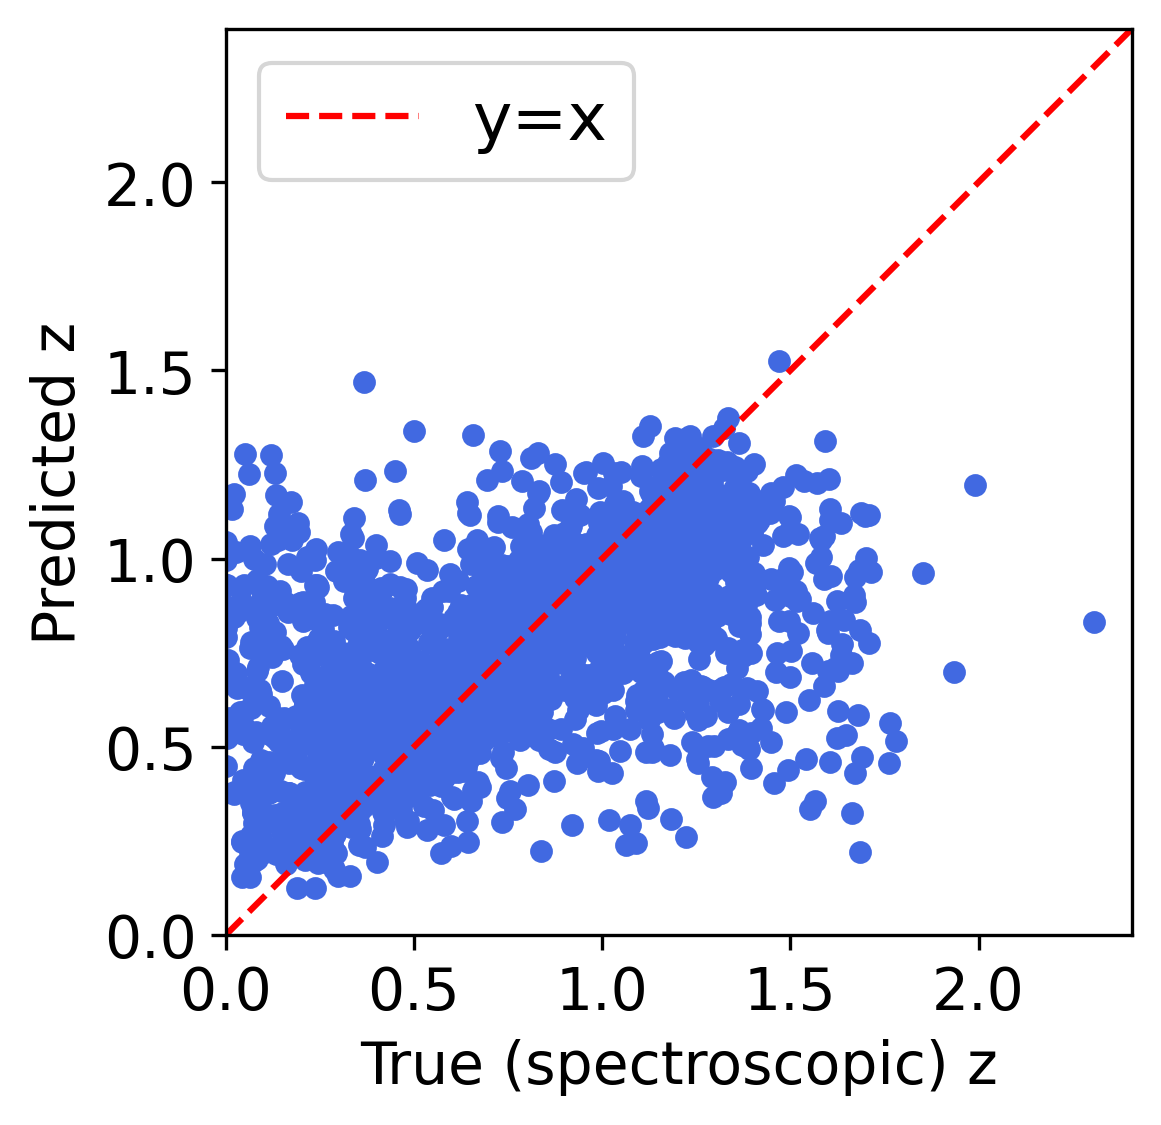

In [46]:
ypred = scalert.inverse_transform(ypred_test.reshape(-1,1))
plt.scatter(selt_test, ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
x = np.linspace(0,np.max(selt_test)+0.1,100)
y = x
plt.plot(x, y, linestyle='dashed', c='r', label='y=x')
index = np.random.randint(0, len(selt_test), 20)
plt.axis('square')
plt.legend()
plt.xlim(0,np.max(selt_test)+0.1)
plt.ylim(0,np.max(selt_test)+0.1)

In [47]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [48]:
np.random.randint(0, 10, 20)

array([6, 0, 6, 6, 7, 2, 1, 5, 3, 8, 3, 9, 2, 3, 5, 5, 0, 2, 6, 9])

In [49]:
mse_test =  mean_squared_error(selt_test, scalert.inverse_transform(ypred_test.reshape(-1,1)))
mse_test

0.1083092700519866

In [50]:
mean_test = np.mean(scalert.inverse_transform(ypred_test.reshape(-1,1)))
mean_test

0.7229059297485229

In [51]:
std_test = np.std(scalert.inverse_transform(ypred_test.reshape(-1,1)))
std_test

0.25455173499219125

In [52]:
ypred_train = cross_val_predict(model,seld_sc, selt_sc, \
        cv = KFold(n_splits=5, shuffle=True, random_state=10))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

In [55]:
scores = cross_validate(model, seld_sc, selt_sc, \
    cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                        return_train_score=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isidro/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

In [56]:
scores

{'fit_time': array([0.26450849, 0.25404286, 0.23772359, 0.24068737, 0.24173355]),
 'score_time': array([0.00160933, 0.00158787, 0.00170279, 0.00176477, 0.00163579]),
 'test_score': array([0.32165947, 0.36508898, 0.35110305, 0.34459958, 0.33889804]),
 'train_score': array([0.67021288, 0.66275729, 0.66682886, 0.66828693, 0.66936841])}

In [53]:
mse_train = mean_squared_error(scalert.inverse_transform(selt_sc.reshape(-1,1)), scalert.inverse_transform(ypred_train.reshape(-1,1)))
mse_train

0.09899543315723774

### And the verdict is....

### Challenge: can you use some of the things we learned, the paper, and your own knowledge (possibly) to match the paper's results?



- FEature engieeniering
- REdshift range
- Missing values
- Review paper